# Package installation

In [ ]:
!pip install keras-core
!pip install -q keras-nlp
# !pip install tensorflow==2.15.*
# !pip install tensorflow-text

# Connecting to drive for Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Requirements File

In [3]:
pip freeze > requirements.txt

In [4]:
import re
from collections import defaultdict
import keras
import keras_nlp
import tensorflow as tf
# import keras_core as keras
import numpy as np
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import feature_extraction
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


In [5]:
!pip install nltk
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
print("TensorFlow version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)

TensorFlow version: 2.16.1
KerasNLP version: 0.9.3


# Loading the dataset and understanding

In [7]:
df__tweet_tr = pd.read_csv('/content/drive/MyDrive/train.csv', index_col=0)
# df__tweet_te = pd.read_csv('/content/drive/MyDrive/test.csv', index_col=0)


In [8]:
df__tweet_tr.head(5)

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [9]:
# df__tweet_te.head(5)

# Parameter Settings Table

In [10]:
BATCH_SIZE = 20
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
NUM_TRAINING_EXAMPLES = df__tweet_tr.shape[0]
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE
EPOCHS = 7
AUTO = tf.data.experimental.AUTOTUNE

np.random.seed(0)
keras.utils.set_random_seed(0)

In [11]:
# Function to display confusion matrix
def dgetConfusionMatrix(y_true, y_pred, dataset,model_name):
    colors = ['#FFFFFF', '#F4BBFF', '#FFC1E0', '#A64CA6']
    try:
        disp = ConfusionMatrixDisplay.from_predictions(
            y_true,
            np.argmax(y_pred, axis=1),
            display_labels=["Not Disaster","Disaster"],
            cmap=plt.cm.Blues

        )
        tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    except Exception as e:
        disp = ConfusionMatrixDisplay.from_predictions(
            y_true,
            y_pred,
            display_labels=["Not Disaster","Disaster"],
            cmap=plt.cm.Blues

        )
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + "Dataset | F1 Score: " + str(f1_score.round(2)))
    plt.savefig('Figures/' + model_name + '_' + dataset + '_confusion_matrix.png')


# Exploratory Data Analysis

Number of words in tweets based on the class

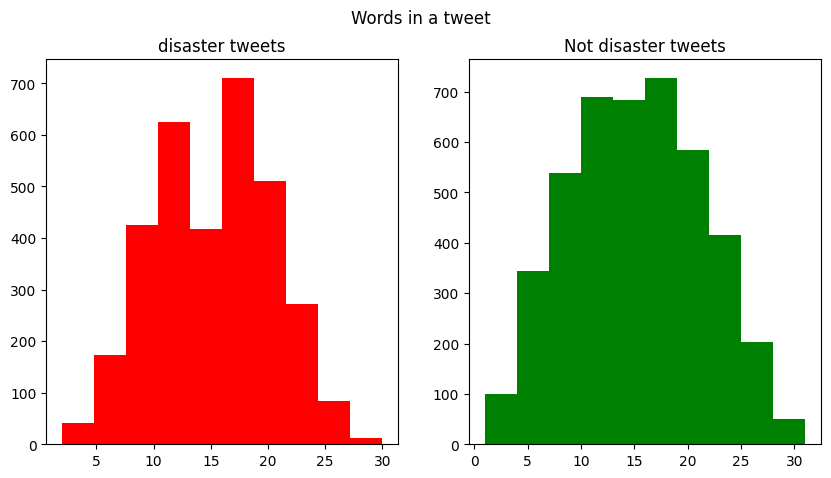

<Figure size 640x480 with 0 Axes>

In [13]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=df__tweet_tr[df__tweet_tr['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=df__tweet_tr[df__tweet_tr['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()
plt.savefig('Figures/number0fWords.png')

Creating the corpus for analysis of data

In [14]:
def create_tweet_corpus(tweet, target):
    corpus=[]

    for x in tweet[tweet['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [15]:
corpus_new = create_tweet_corpus(df__tweet_tr, 1)
len(corpus_new)

49613

Plot to display the punctuations in the tweets

In [16]:
import string
def displayPunctuations(corpus):
  dic=defaultdict(int)
  special = string.punctuation
  for i in (corpus):
    if i in special:
        dic[i]+=1

  return zip(*dic.items())


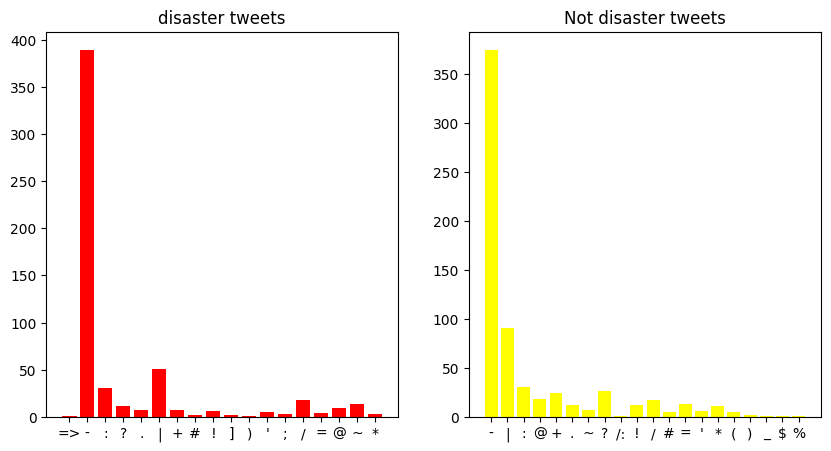

In [17]:

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
corpus=create_tweet_corpus(df__tweet_tr,1)
x,y =displayPunctuations(corpus)
ax1.bar(x,y,color='red')
ax1.set_title('disaster tweets')

corpus=create_tweet_corpus(df__tweet_tr,0)
x,y =displayPunctuations(corpus)
ax2.bar(x,y,color='yellow')
ax2.set_title('Not disaster tweets')
plt.savefig('Figures/punctuationfor1.png')

Analysing the most common words in the tweet

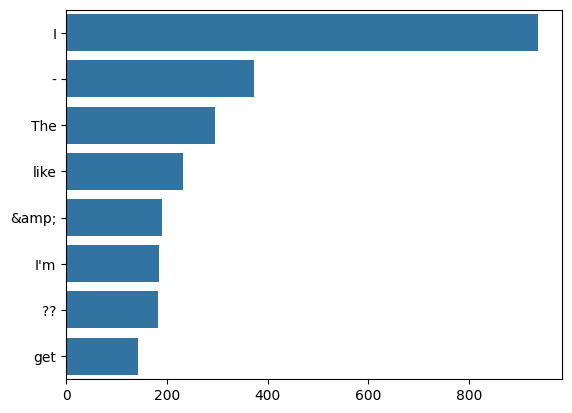

In [18]:
from collections import  Counter
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)
sns.barplot(x=y,y=x)
plt.savefig('Figures/commonwords.png')


In [19]:
# df=pd.concat([df__tweet_tr,df__tweet_te])
# df.shape

Analysing the Bigrams in the tweets

In [20]:
def tweets_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

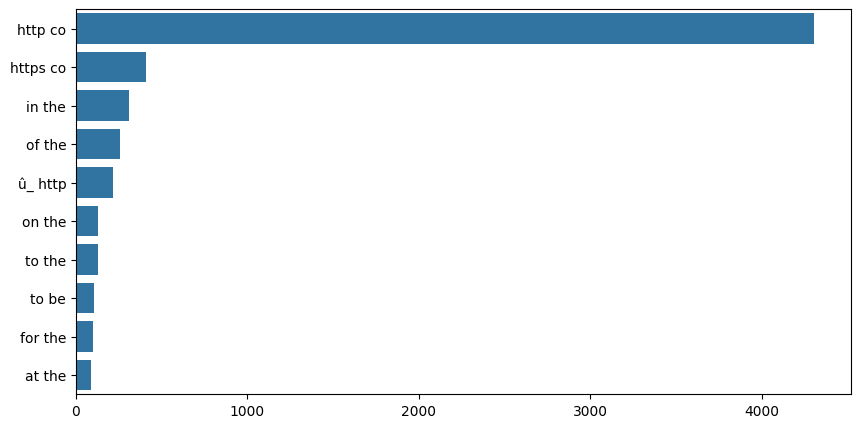

In [21]:
plt.figure(figsize=(10,5))
top_tweet_bigrams=tweets_bigrams(df__tweet_tr['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)
plt.savefig('Figures/bigram.png')

# Data cleaning

In [22]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)


In [23]:
df__tweet_tr['text']=df__tweet_tr['text'].apply(lambda x : remove_URL(x))

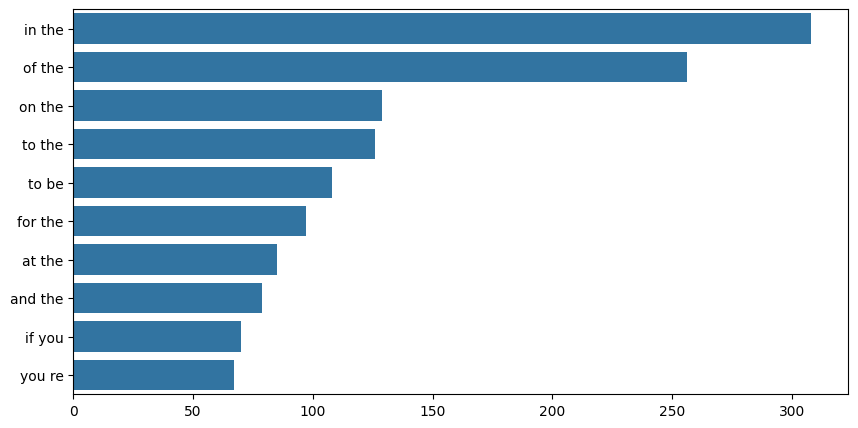

In [24]:
plt.figure(figsize=(10,5))
top_tweet_bigrams=tweets_bigrams(df__tweet_tr['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)
plt.savefig('Figures/CleanedDatabigram.png')

In [25]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

In [26]:
df__tweet_tr['text']=df__tweet_tr['text'].apply(lambda x : remove_punct(x))

Words Cloud after Data Cleaning

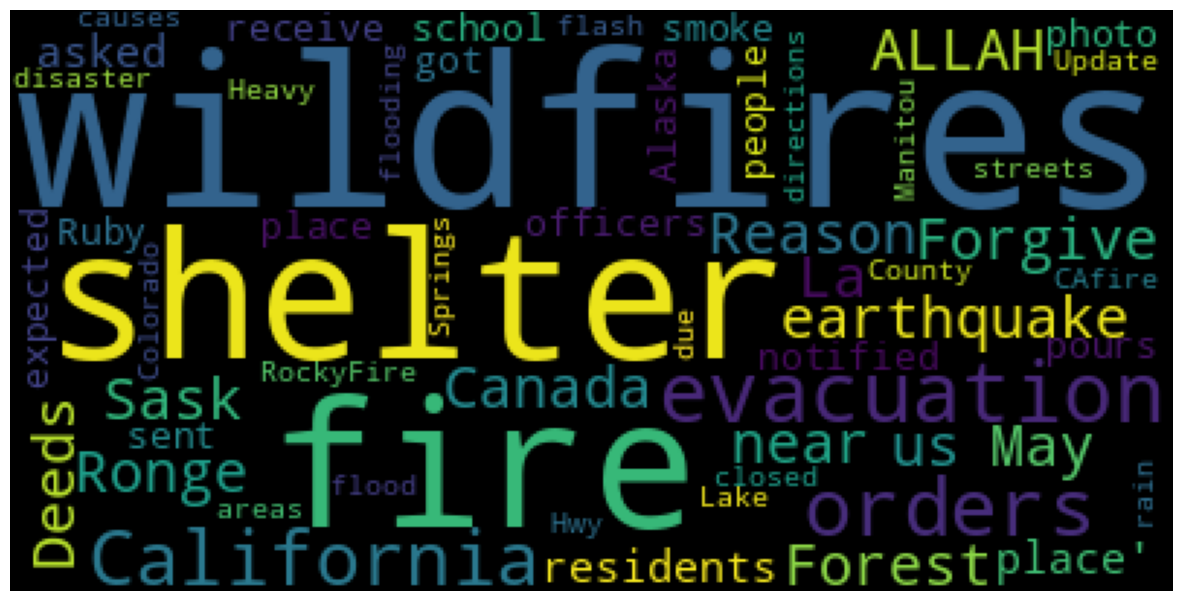

<Figure size 640x480 with 0 Axes>

In [27]:
plt.figure(figsize=(15, 10))
word_cloud = WordCloud(max_font_size=80).generate(" ".join(corpus_new[:100]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()
plt.savefig('Figures/wordsCloud2.png')

# Convert from text to vectors

In [28]:
count_vectorizer = feature_extraction.text.CountVectorizer()

In [29]:
count_vectorizer.fit(df__tweet_tr['text'])

CountVectorizer()

In [30]:
df__tweet_tr_embedded = count_vectorizer.transform(df__tweet_tr['text'])
# df__tweet_te_embedded = count_vectorizer.transform(df__tweet_te['text'])

# Logistic Regression for tweets classification

In [31]:
X = df__tweet_tr["text"]
y = df__tweet_tr["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)

# X_test = df__tweet_te["text"]

In [32]:
X_train_embedded = count_vectorizer.transform(X_train)
X_val_embedded = count_vectorizer.transform(X_val)

In [33]:
logit = LogisticRegression()
logit.fit(X_train_embedded, y_train)


LogisticRegression()

In [34]:
logit.score(X_train_embedded, y_train)


0.9666666666666667

In [35]:
logit.score(X_val_embedded, y_val)


0.8023637557452397

Displaying the confusion matrix for Logistic regression

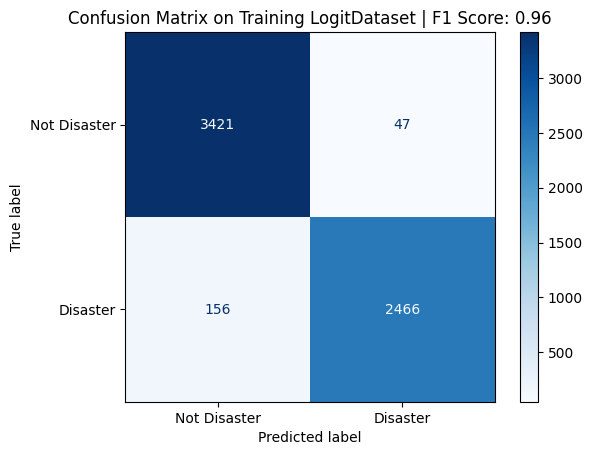

In [36]:
y_pred_train = logit.predict(X_train_embedded)

dgetConfusionMatrix(y_train, y_pred_train, "Training Logit","LogisticRegression")

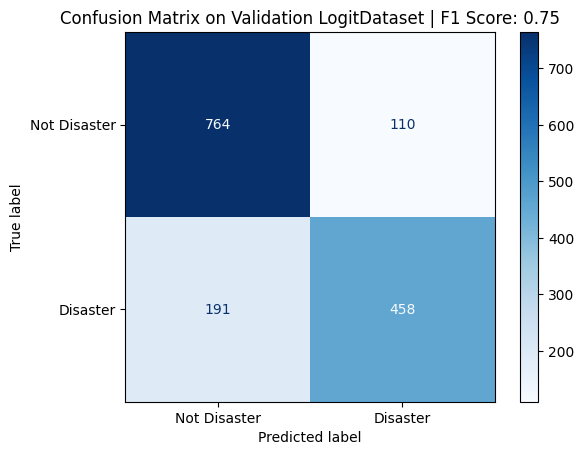

In [37]:
y_pred_val = logit.predict(X_val_embedded)

dgetConfusionMatrix(y_val, y_pred_val, "Validation Logit","LogisticRegression")

# Finetuning the DistilBERT for Tweets analysis

In [38]:
!pip install tensorflow-text

In [39]:
import tensorflow as tf
import tensorflow_text as text
import keras_nlp

In [40]:

preset = "distil_bert_base_en_uncased"

preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
                                                                   sequence_length=160,
                                                                   name="tweets_preprocessor"
                                                                  )


classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                               preprocessor = preprocessor,
                                                               num_classes=2)

classifier.summary()

100%|██████████| 580/580 [00:00<00:00, 533kB/s]
100%|██████████| 226k/226k [00:00<00:00, 2.07MB/s]
100%|██████████| 515/515 [00:00<00:00, 314kB/s]
100%|██████████| 253M/253M [00:03<00:00, 75.8MB/s]


Preprocessor: "tweets_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)        │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
classifier.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-5),
    metrics= ["accuracy"]
)

history = classifier.fit(x=X_train,
                         y=y_train,
                         batch_size=15,
                         epochs=4,
                         validation_data=(X_val, y_val)
                        )

Epoch 1/4
406/406 ━━━━━━━━━━━━━━━━━━━━ 190s 233ms/step - accuracy: 0.7378 - loss: 0.5364 - val_accuracy: 0.8365 - val_loss: 0.3985
Epoch 2/4
406/406 ━━━━━━━━━━━━━━━━━━━━ 88s 216ms/step - accuracy: 0.8468 - loss: 0.3632 - val_accuracy: 0.8404 - val_loss: 0.3940
Epoch 3/4
406/406 ━━━━━━━━━━━━━━━━━━━━ 125s 309ms/step - accuracy: 0.8794 - loss: 0.3020 - val_accuracy: 0.8221 - val_loss: 0.4410
Epoch 4/4
406/406 ━━━━━━━━━━━━━━━━━━━━ 86s 211ms/step - accuracy: 0.9118 - loss: 0.2394 - val_accuracy: 0.8070 - val_loss: 0.4860


In [42]:
history.history

{'accuracy': [0.7888341546058655,
  0.8530377745628357,
  0.8822659850120544,
  0.9126436710357666],
 'loss': [0.46626967191696167,
  0.3567085266113281,
  0.29777684807777405,
  0.24233859777450562],
 'val_accuracy': [0.8365069031715393,
  0.8404464721679688,
  0.8220617175102234,
  0.8069599270820618],
 'val_loss': [0.3984922170639038,
  0.39396750926971436,
  0.44096195697784424,
  0.4860060513019562]}

In [43]:

def plots_distilbert(history,fig_name):
  # Plotting training history
  plt.figure(figsize=(10, 5))

  # Plot training & validation accuracy values
  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.grid(True)

  # Plot training & validation loss values
  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'], label='Training Loss', marker='o')
  plt.plot(history.history['val_loss'], label='Validation Loss', marker='s')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)

  plt.tight_layout()
  plt.show()
  plt.savefig('Figures/'+fig_name+'.png')

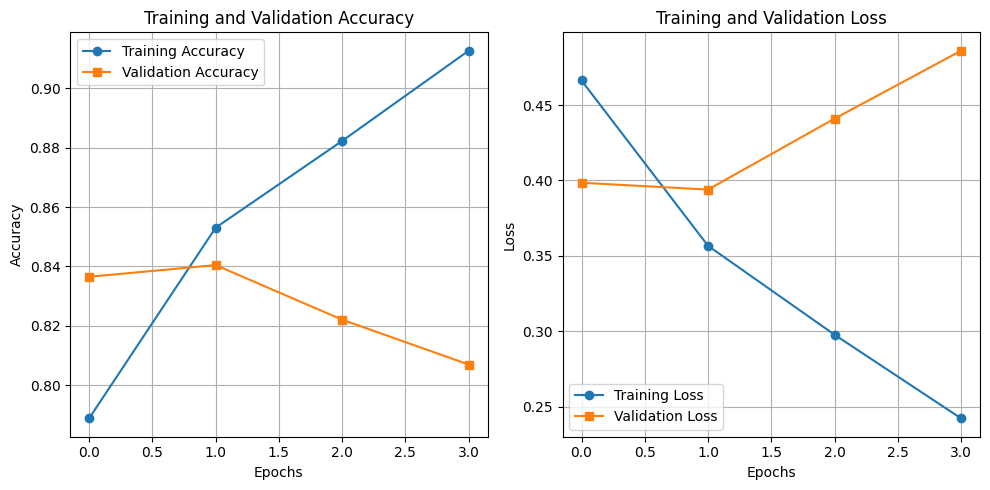

<Figure size 640x480 with 0 Axes>

In [44]:
plots_distilbert(history,"noautotune") #without autotune

191/191 ━━━━━━━━━━━━━━━━━━━━ 41s 195ms/step


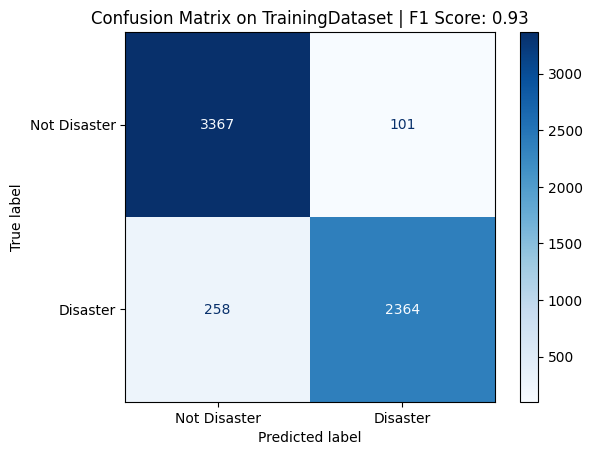

In [45]:
y_pred_train = classifier.predict(X_train)

dgetConfusionMatrix(y_train, y_pred_train, "Training","Distilbert")

48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 164ms/step


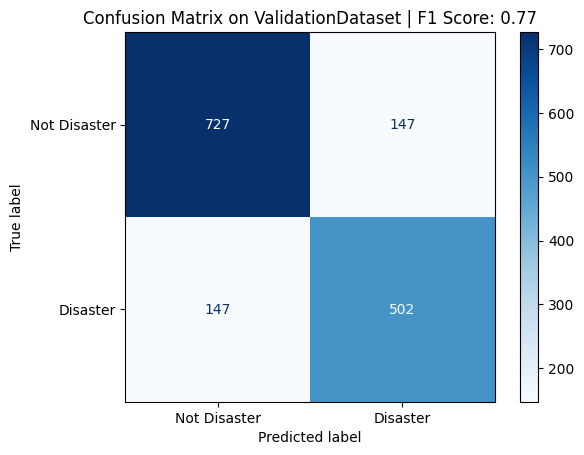

In [46]:
y_pred_val = classifier.predict(X_val)

dgetConfusionMatrix(y_val, y_pred_val, "Validation","Distilbert")

In [47]:

# Apply preprocessing operations to the datasets
preset = "distil_bert_base_en_uncased"
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(
    preset,
    sequence_length=160,
    name="tweets_preprocessor_autotune"
)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

# Apply AUTOTUNE to optimize data loading and processing
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Now train the classifier using the prepared datasets
history_autotune = classifier.fit(
    x=train_dataset,
    # batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_dataset
)

Epoch 1/7
305/305 ━━━━━━━━━━━━━━━━━━━━ 204s 480ms/step - accuracy: 0.9332 - loss: 0.2012 - val_accuracy: 0.8247 - val_loss: 0.4877
Epoch 2/7
305/305 ━━━━━━━━━━━━━━━━━━━━ 126s 411ms/step - accuracy: 0.9463 - loss: 0.1618 - val_accuracy: 0.8227 - val_loss: 0.5656
Epoch 3/7
305/305 ━━━━━━━━━━━━━━━━━━━━ 88s 287ms/step - accuracy: 0.9555 - loss: 0.1307 - val_accuracy: 0.8129 - val_loss: 0.6386
Epoch 4/7
305/305 ━━━━━━━━━━━━━━━━━━━━ 122s 400ms/step - accuracy: 0.9631 - loss: 0.1045 - val_accuracy: 0.8004 - val_loss: 0.7799
Epoch 5/7
305/305 ━━━━━━━━━━━━━━━━━━━━ 88s 287ms/step - accuracy: 0.9717 - loss: 0.0814 - val_accuracy: 0.8070 - val_loss: 0.7633
Epoch 6/7
305/305 ━━━━━━━━━━━━━━━━━━━━ 122s 399ms/step - accuracy: 0.9739 - loss: 0.0748 - val_accuracy: 0.8030 - val_loss: 0.8788
Epoch 7/7
305/305 ━━━━━━━━━━━━━━━━━━━━ 92s 300ms/step - accuracy: 0.9782 - loss: 0.0595 - val_accuracy: 0.8070 - val_loss: 0.8630


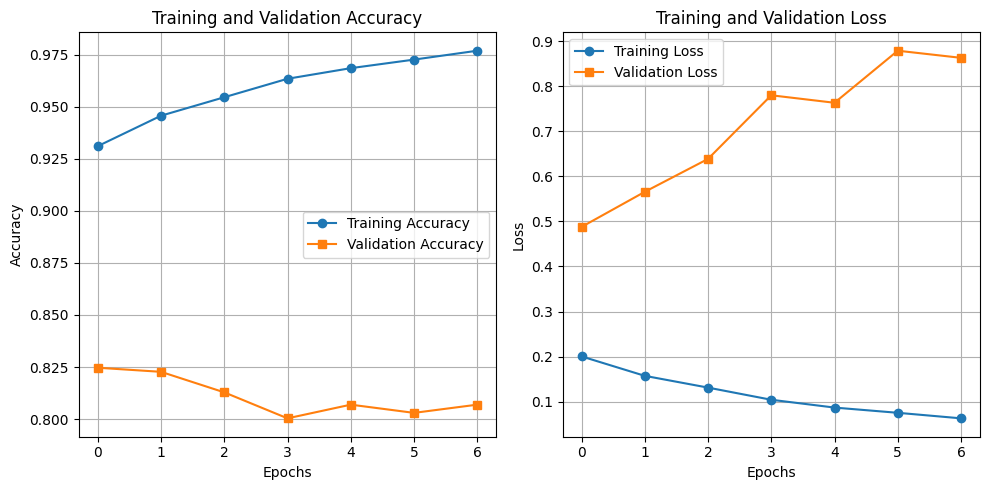

<Figure size 640x480 with 0 Axes>

In [48]:
plots_distilbert(history_autotune,"autotune") #with autotune

191/191 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step


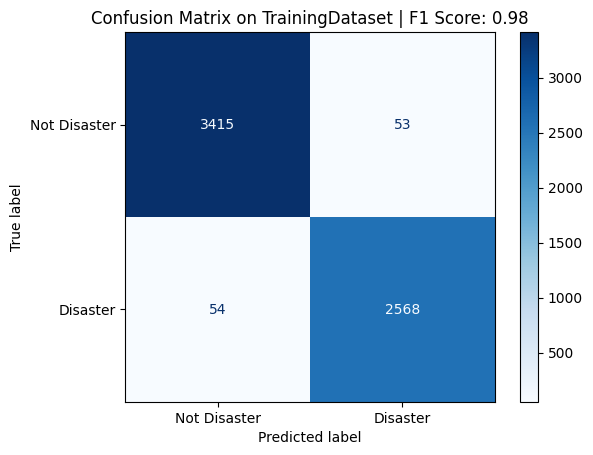

In [49]:
y_pred_train = classifier.predict(X_train)

dgetConfusionMatrix(y_train, y_pred_train, "Training","Distilbert_autotune")

48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step


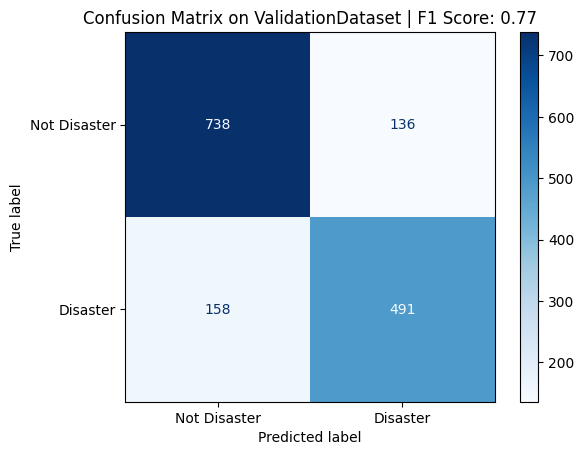

In [50]:
y_pred_val = classifier.predict(X_val)

dgetConfusionMatrix(y_val, y_pred_val, "Validation","Distilbert_autotune")

In [65]:
# downloading figures
%cd /content/
!zip -r Figures.zip Figures/
from google.colab import files

files.download('Figures.zip')


/content
updating: Figures/ (stored 0%)
updating: Figures/bigram.png (deflated 26%)
updating: Figures/CleanedDatabigram.png (deflated 28%)
updating: Figures/wordsCloud2.png (deflated 90%)
updating: Figures/noautotune.png (deflated 90%)
updating: Figures/Distilbert_Validation_confusion_matrix.png (deflated 15%)
updating: Figures/punctuationfor1.png (deflated 23%)
updating: Figures/LogisticRegression_Training Logit_confusion_matrix.png (deflated 14%)
updating: Figures/Distilbert_Training_confusion_matrix.png (deflated 14%)
updating: Figures/autotune.png (deflated 90%)
updating: Figures/number0fWords.png (deflated 90%)
updating: Figures/Distilbert_autotune_Validation_confusion_matrix.png (deflated 16%)
updating: Figures/LogisticRegression_Validation Logit_confusion_matrix.png (deflated 15%)
updating: Figures/commonwords.png (deflated 24%)
updating: Figures/Distilbert_autotune_Training_confusion_matrix.png (deflated 15%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>